In [1]:
%pip install pandas


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# load data
import pandas as pd
df_raw = pd.read_csv("PRONTOBenchmarkTest9.csv")

# clean data
df_raw.head()
colnames = df_raw.iloc[1].tolist()
df = df_raw.iloc[2:].copy()
df.columns = colnames
df = df.reset_index(drop=True)
df.head()

,TIMESTAMP,Air In1,Air In2,Air T,Air P,Water In1,Water In2,Water T,Water Density,Mixture zone P,...,NaN,NaN,Air In 2,Air In 2,Water In1,Water In1,NaN,Water In 2,Water In 2,NaN
0,09/12/2017 10:00,99.7911377,0.002018351,16.46453094,1.157050967,0.00014997,0.008798941,18.75638962,998.2576294,1.131950021,...,99.69100189,0,100.0009995,0.002018351,0,0,0.00014997,0,0,0.00879894
1,09/12/2017 10:00,99.84359741,0.00171826,16.46552086,1.157019019,0.000150975,0.008799082,18.75638962,998.2578125,1.131800056,...,99.74504089,0,100.0009995,0.00171826,0,0,0.000150975,0,0,0.00879908
2,09/12/2017 10:00,99.84837341,0.001418168,16.46649933,1.156985998,0.000151979,0.008799221,18.51082993,998.2579956,1.131649971,...,99.79908752,0,100.0009995,0.001418168,0,0,0.000151979,0,0,0.00879922
3,09/12/2017 10:00,99.8245163,0.001118076,16.46748924,1.15695405,0.000152983,0.008799362,18.51082993,998.2581787,1.131646037,...,99.85312653,0,100.0009995,0.001118076,0,0,0.000152983,0,0,0.008799361
4,09/12/2017 10:00,99.77205658,4.008059978,16.46846962,1.156921983,0.000153988,0.008799502,18.51082993,998.2583008,1.131641984,...,99.79795074,0,100.0009995,4.008059978,0,0,0.000153988,0,0,0.008799502


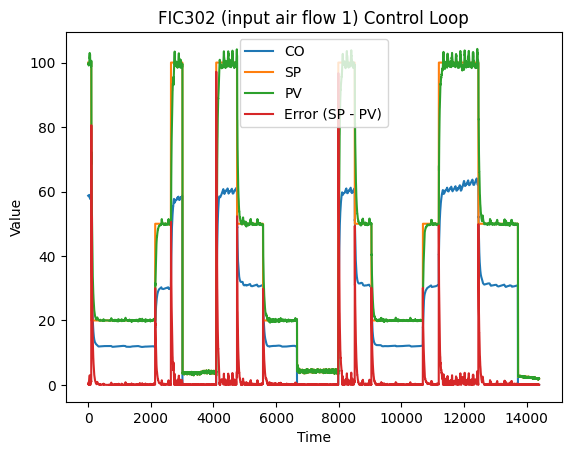

In [ ]:
# Q2: Integral Windup for PID Controller

import matplotlib.pyplot as plt

controller_output = df.iloc[:, 20].astype(float)   # controller output (OUT), feature 20
setpoint = df.iloc[:, 21].astype(float)   # setpoint (SP), feature 21
process_value = df.iloc[:, 22].astype(float)   # process variable (PV), feature 22
error = abs(setpoint - process_value)

# plot everything
plt.figure()
plt.plot(controller_output, label="CO")
plt.plot(setpoint, label="SP")
plt.plot(process_value, label="PV")
plt.plot(error, label="Error (SP - PV)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("FIC302 (input air flow 1) Control Loop")
plt.legend()
plt.show()

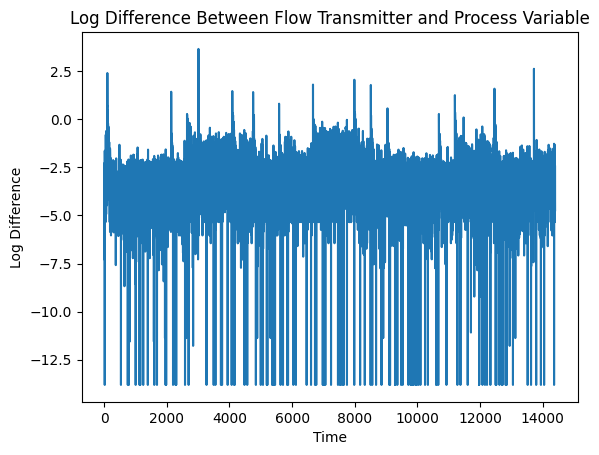

In [4]:
# Q5: Numerical Differences Between (i) Value of Process Variable and (i) Value of PID Controller Input
# for Same Process Variable at Same Time
import numpy as np

flow_transmitter = df.iloc[:, 1].astype(float)   # flow transmitter, feature 1
process_value = df.iloc[:, 22].astype(float)   # process variable (PV), feature 22
diff = abs(flow_transmitter - process_value)
diff = diff.replace(0, 1e-6)
log_diff = np.log(diff)

plt.figure()
plt.plot(log_diff)
plt.xlabel("Time")
plt.ylabel("Log Difference")
plt.title("Log Difference Between Flow Transmitter and Process Variable")
plt.show()

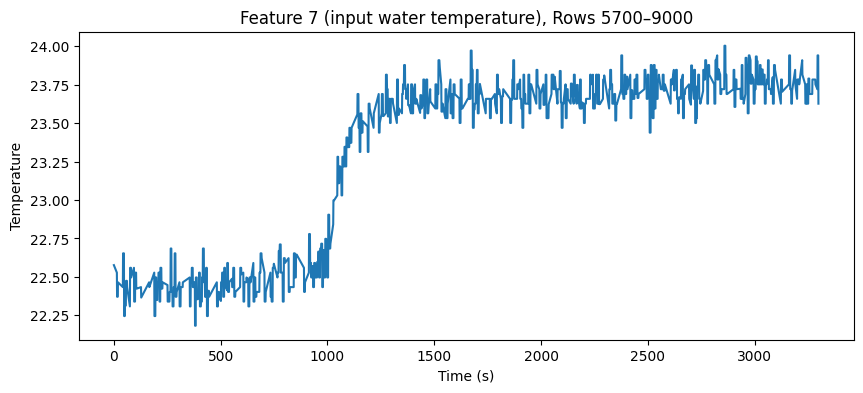

In [ ]:
# Q6: Low-Pass Signal Filters: Lag vs. Variability of Derivative Term in PID Control 
# get feature 7, input water temperature, rows 5700 to 9000 
water_temp = pd.to_numeric(df.iloc[5700:9000, 7], errors='coerce').to_numpy()

# plot to see where the jump starts/ends
plt.figure(figsize=(10,4))
plt.plot(water_temp)
plt.title("Feature 7 (input water temperature), Rows 5700–9000")
plt.xlabel("Time (s)")
plt.ylabel("Temperature")
plt.show()

In [ ]:
# Q6 (continued)
from scipy.signal import savgol_filter

delta_x = np.diff(water_temp)
jump_idx = 1000 
low_plateau  = water_temp[:750].mean() # based on graph
high_plateau = water_temp[1500:].mean() # based on graph
halfway_point = 0.5 * (low_plateau + high_plateau)
derivative_plateau_start = 1500
derivative_plateau_end = 3500

def compute_lag_time_and_derivative_variability(water_temp_filtered):
  # lag time (time from start of jump to halfway point)
  lag_idx = np.argmax(water_temp_filtered[jump_idx:] >= halfway_point) + jump_idx
  lag_time = lag_idx - jump_idx
  
  # derivative variability (std of differences on high plateau)
  derivative = np.diff(water_temp_filtered[derivative_plateau_start:derivative_plateau_end])
  variability = np.std(derivative)
  return lag_time, variability

results = []

# simple moving average
for n in [2, 8, 32, 64, 128]:
  weights = np.ones(n) / n
  sma = np.convolve(water_temp, weights, mode='valid')
  lag, var = compute_lag_time_and_derivative_variability(sma)
  results.append(("Simple Moving Average", n, lag, var))

# exponential moving average
for weighting_factor in [0.2, 0.5, 0.8]:
  n = 63
  ema = np.zeros(len(water_temp))
  sma = np.mean(water_temp[:63])
  ema[n - 1] = sma
  for i in range(n, len(water_temp)):
    ema[i] = (water_temp[i] * weighting_factor) + (ema[i - 1] * (1 - weighting_factor))
  lag, var = compute_lag_time_and_derivative_variability(ema)
  results.append(("Exponential Moving Average", weighting_factor, lag, var))

# savitzky-golay filter
for polynomial_order in [3, 6, 9]:
  water_temp_smoothed = savgol_filter(water_temp, 63, polynomial_order)
  lag, var = compute_lag_time_and_derivative_variability(water_temp_smoothed)
  results.append(("Savitzky-Golay", polynomial_order, lag, var))

table = pd.DataFrame(results, columns=["Filter", "Param", "Lag", "Derivative Variability"])
print(table)

                        Filter  Param  Lag  Derivative Variability
0        Simple Moving Average    2.0   46                0.040466
1        Simple Moving Average    8.0   41                0.016353
2        Simple Moving Average   32.0   28                0.003963
3        Simple Moving Average   64.0   18                0.002008
4        Simple Moving Average  128.0    0                0.001039
5   Exponential Moving Average    0.2   48                0.015749
6   Exponential Moving Average    0.5   47                0.032552
7   Exponential Moving Average    0.8   47                0.046864
8               Savitzky-Golay    3.0   43                0.003741
9               Savitzky-Golay    6.0   43                0.008757
10              Savitzky-Golay    9.0   45                0.012461


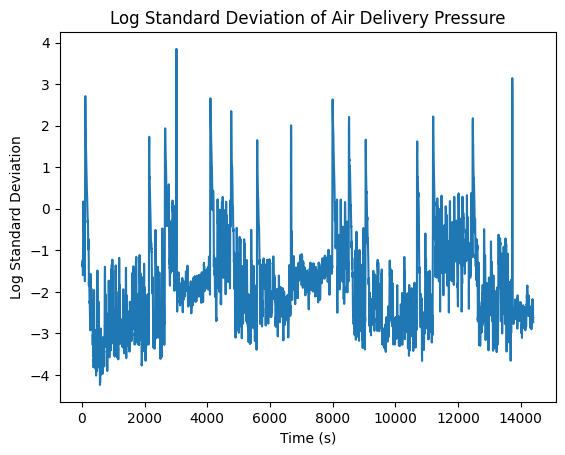

In [ ]:
# Q7: Noise Variability & Fault Detection 
air_delivery_pressure = df.iloc[:, 1].astype(float) # feature 4, air delivery pressure
window_size = 16
std_dev = air_delivery_pressure.rolling(window=window_size).std()  # compute rolling std
log_std_dev = np.log(std_dev + 1e-6)  # avoid log(0)
plt.figure()
plt.plot(log_std_dev)
plt.xlabel("Time (s)")
plt.ylabel("Log Standard Deviation")
plt.title("Log Standard Deviation of Air Delivery Pressure")
plt.show()

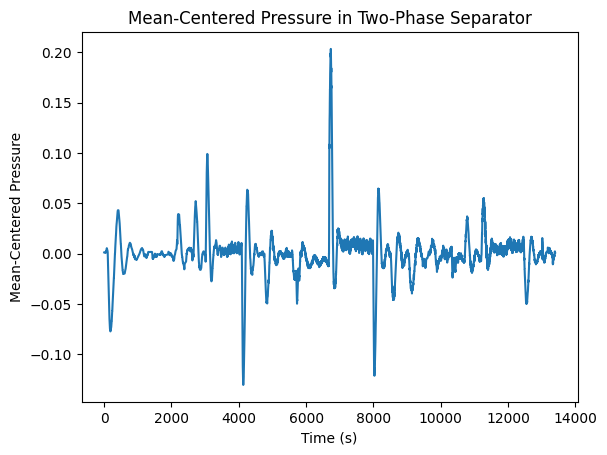

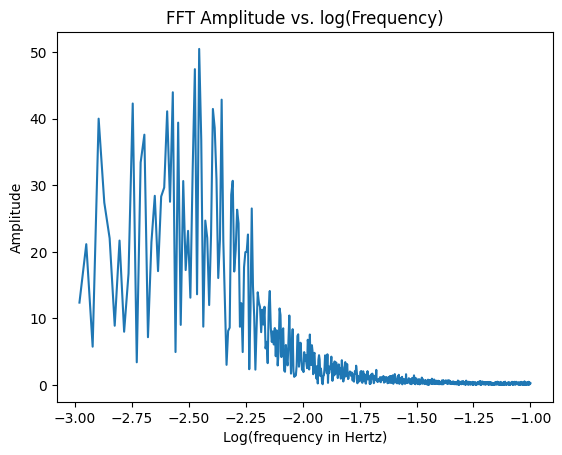

In [17]:
# Q8: Different Times Scales for Signal Variability

from scipy.fftpack import fft, ifft, fftfreq

# feature 11, pressure in the two-phase separator, ignore last 1000 points
pressure = df.iloc[:-1000, 11].astype(float) 
pressure_mean_centered = pressure - pressure.mean()

plt.figure()
plt.plot(pressure_mean_centered)
plt.title("Mean-Centered Pressure in Two-Phase Separator")
plt.xlabel("Time (s)")
plt.ylabel("Mean-Centered Pressure")
plt.show()

# FFT
X = fft(pressure_mean_centered.to_numpy())
sampling_frequency = 1 
freq = fftfreq(len(pressure_mean_centered), d=sampling_frequency)
mask = (freq > 0) & (freq <= 0.1) & (freq >= 0.001) # 0.001 < freq < 0.1

# Plot FFT amplitude vs. log(frequency)
plt.figure()
plt.plot(np.log10(freq[mask]), np.abs(X[mask]))
plt.title("FFT Amplitude vs. log(Frequency)")
plt.xlabel("Log(frequency in Hertz)")
plt.ylabel("Amplitude")
plt.show()
